In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler

In [2]:
from pathlib import Path
import requests

In [3]:
csvpath = Path("NSETata.csv")

In [4]:
df = pd.read_csv(csvpath, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [5]:
df.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [6]:
df = df.reset_index()

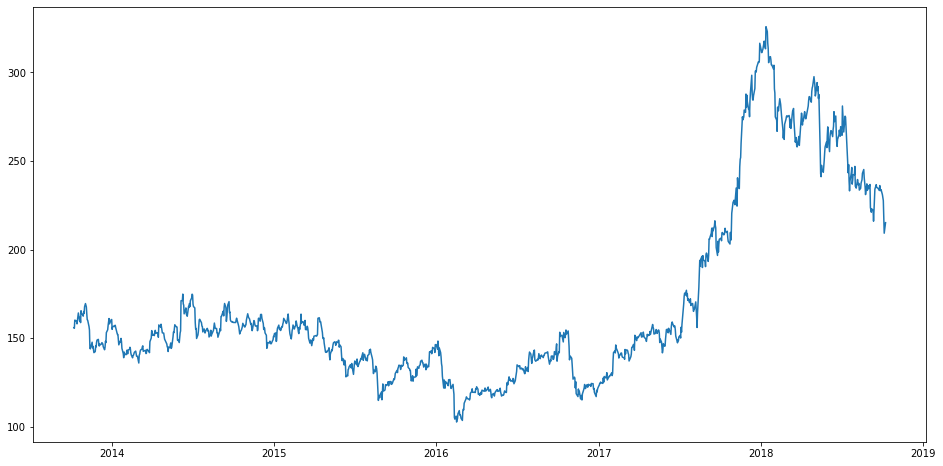

In [7]:
df['Date'] = pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [8]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2018-10-08,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
2018-10-05,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2018-10-04,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
2018-10-03,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-01,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [9]:
data = df.sort_index(ascending=True,axis=0)

In [10]:
new_dataset = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i] = data['Date'][i]
    new_dataset["Close"][i] = data["Close"][i]

In [11]:
new_dataset = new_dataset.set_index('Date')

In [12]:
#final_dataset

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
final_dataset = new_dataset.to_numpy()

train_data = final_dataset[0:987,:]
valid_data = final_dataset[987:,:]


#new_dataset.drop(["Date"],axis=1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_dataset)

x_train_data,y_train_data = [],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data = np.array(x_train_data),np.array(y_train_data)

x_train_data = np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [14]:
lstm_model = Sequential()

lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

In [15]:
inputs_data = new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

927/927 - 4s - loss: 0.0011


In [16]:
X_test = []
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test = np.array(X_test)

In [17]:
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

In [18]:
lstm_model.save("saved_model.h5")

In [19]:
train_data = new_dataset[:987]
valid_data = new_dataset[987:]

In [20]:
valid_data

,Close
Date,
2017-10-09,208.3
2017-10-10,208.45
2017-10-11,209.4
2017-10-12,212.0
2017-10-13,210.25
...,...
2018-10-01,230.9
2018-10-03,227.6
2018-10-04,218.2


In [21]:
predicted_closing_price

array([[203.194  ],
       [264.3807 ],
       [305.56125],
       [260.91318],
       [269.76617],
       [257.51483],
       [261.8066 ],
       [229.76962]], dtype=float32)

In [22]:
#valid_data['Predictions'] = predicted_closing_price

predicted = pd.DataFrame(predicted_closing_price)

In [23]:
import datetime

In [24]:
# %Y-%m-%d

dates = pd.date_range("2018-10-09", periods=8, freq="D")
dates

DatetimeIndex(['2018-10-09', '2018-10-10', '2018-10-11', '2018-10-12',
               '2018-10-13', '2018-10-14', '2018-10-15', '2018-10-16'],
              dtype='datetime64[ns]', freq='D')

In [25]:
predicted = pd.DataFrame(predicted_closing_price, index=dates)
predicted

,0
2018-10-09,203.194000
2018-10-10,264.380707
2018-10-11,305.561249
2018-10-12,260.913177
2018-10-13,269.766174
2018-10-14,257.514832
2018-10-15,261.806610
2018-10-16,229.769623


In [26]:
predicted.rename(columns={0: "Predictions"}, inplace=True)

In [27]:
predicted

,Predictions
2018-10-09,203.194000
2018-10-10,264.380707
2018-10-11,305.561249
2018-10-12,260.913177
2018-10-13,269.766174
2018-10-14,257.514832
2018-10-15,261.806610
2018-10-16,229.769623


In [28]:
final_frames = [valid_data, predicted]

valid_data = pd.concat(final_frames, axis=0, join="outer")

In [29]:
valid_data

,Close,Predictions
2017-10-09,208.3,NaN
2017-10-10,208.45,NaN
2017-10-11,209.4,NaN
2017-10-12,212.0,NaN
2017-10-13,210.25,NaN
...,...,...
2018-10-12,NaN,260.913177
2018-10-13,NaN,269.766174
2018-10-14,NaN,257.514832
2018-10-15,NaN,261.806610


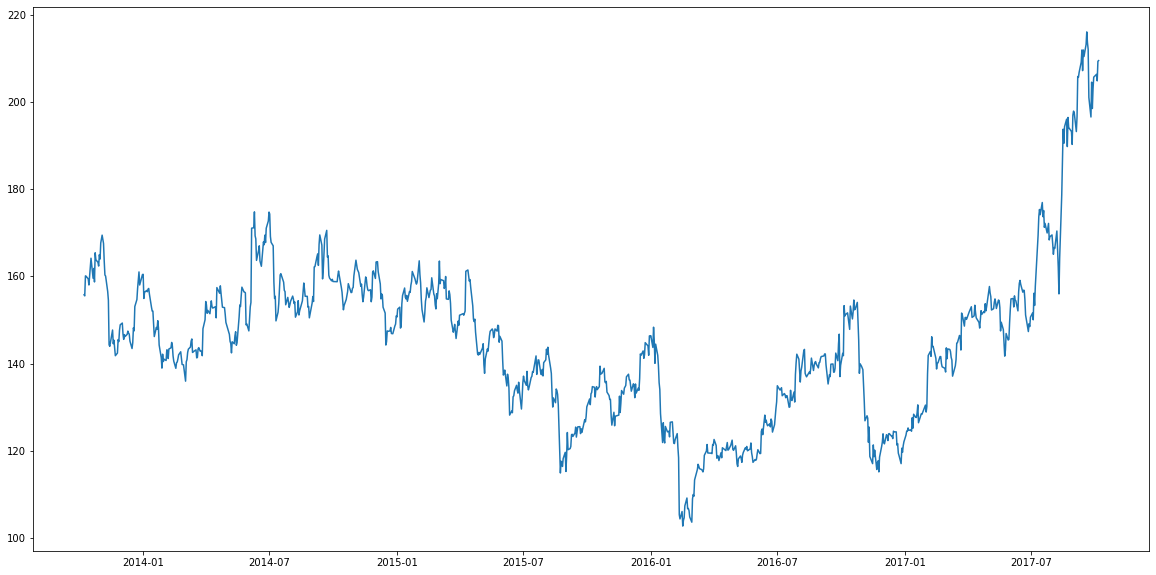

In [31]:
plt.plot(train_data["Close"])

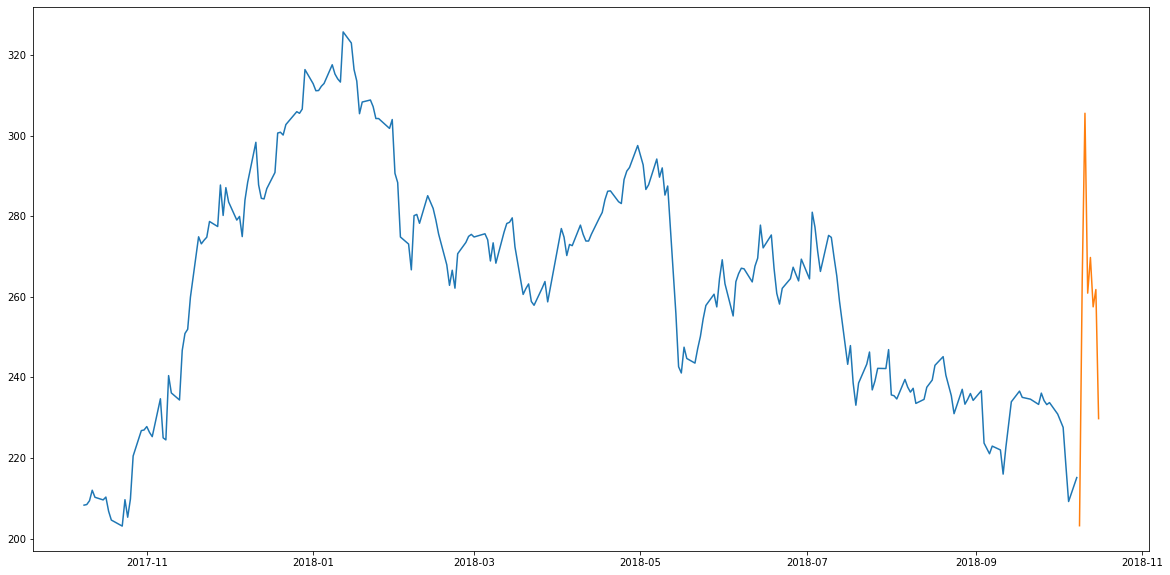

In [32]:
plt.plot(valid_data[['Close','Predictions']])